# Fixed-wake rectangular wing simulation

## 1. import required packages

In [1]:
import csdl
import numpy as np
from VAST.core.fluid_problem import FluidProblem
from VAST.utils.generate_mesh import *
from VAST.core.submodels.input_submodels.create_input_model import CreateACSatesModel
from VAST.core.vlm_llt.vlm_solver import VLMSolverModel
from python_csdl_backend import Simulator

In [2]:
def ex1_generate_model_vlm_fixed_wake(num_nodes,nx, ny):
    fluid_problem = FluidProblem(solver_option='VLM', problem_type='fixed_wake')

    model_1 = csdl.Model()
    ####################################################################
    # 1. add aircraft states
    ####################################################################
    v_inf = np.ones((num_nodes,1))*248.136
    theta = np.deg2rad(np.ones((num_nodes,1))*5)  # pitch angles

    submodel = CreateACSatesModel(v_inf=v_inf, theta=theta, num_nodes=num_nodes)
    model_1.add(submodel, 'InputsModule')
    ####################################################################
    # 2. add VLM meshes
    ####################################################################
    # single lifting surface 
    # (nx: number of points in streamwise direction; ny:number of points in spanwise direction)
    surface_names = ['wing']
    surface_shapes = [(num_nodes, nx, ny, 3)]
    mesh_dict = {
        "num_y": ny, "num_x": nx, "wing_type": "rect", "symmetry": False, "span": 10.0,
        "chord": 1, "span_cos_sppacing": 1.0, "chord_cos_sacing": 1.0,
    }
    # Generate mesh of a rectangular wing
    mesh = generate_mesh(mesh_dict) 
    wing = model_1.create_input('wing', val=np.einsum('i,jkl->ijkl', np.ones((num_nodes)), mesh))

    ####################################################################
    # 3. add VAST solver
    ####################################################################
    if fluid_problem.solver_option == 'VLM':
        eval_pts_shapes = [(num_nodes, x[1] - 1, x[2] - 1, 3) for x in surface_shapes]
        submodel = VLMSolverModel(
            surface_names=surface_names,
            surface_shapes=surface_shapes,
            num_nodes=num_nodes,
            eval_pts_shapes=eval_pts_shapes,
        )
    # wing_C_L_OAS = np.array([0.4426841725811703]).reshape((num_nodes, 1))
    # wing_C_D_i_OAS = np.array([0.005878842561184834]).reshape((num_nodes, 1))
    model_1.add(submodel, 'VLMSolverModel')
    ####################################################################
    
    sim = Simulator(model_1) # add simulator
    return sim

sim = ex1_generate_model_vlm_fixed_wake(num_nodes=1,nx=3, ny=11)
sim.run()


generating: DERIVATIVESy-->gamma_b,MTX,b
y--> (2/2) |........................................|
nonlinear solver: newton solver converged in 1 iterations.


## 3. Visualizing the mesh


No module named 'trame'

Falling back to a static output.


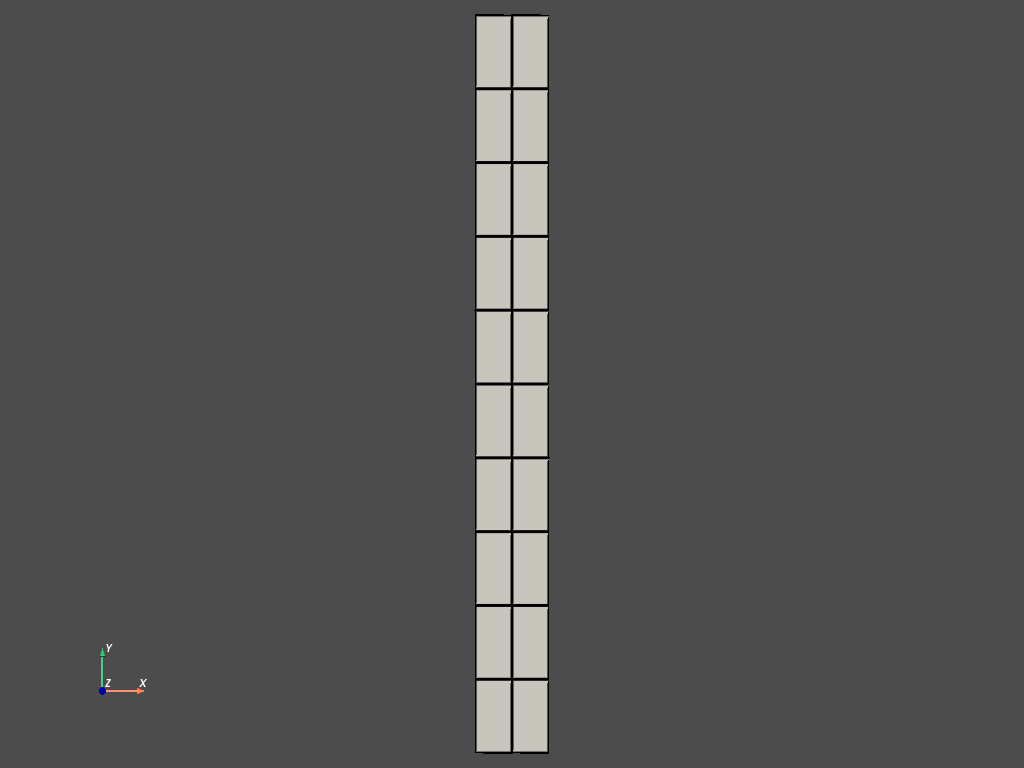

In [7]:
import pyvista as pv

mesh = sim['wing'].reshape((3,11,3))

# Create and plot structured grid
grid = pv.StructuredGrid(mesh[:,:,0], mesh[:,:,1], mesh[:,:,2])

grid.plot(show_edges=True, line_width=3, cpos="xy")


In [11]:
print('the lift coefficient is: ', sim['wing_C_L'])
print('the induced drag coefficient is: ', sim['wing_C_D_i'])

the lift coefficient is:  [[0.44526274]]
the induced drag coefficient is:  [[0.00594827]]
